In [1]:
#general libraries 
import numpy as np 
import pandas as pd 
import os
import random
from sklearn.utils import shuffle
import shutil

#visualizations
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import plotly.express as px
import matplotlib.patches as patches

# work with images
from skimage.transform import rotate
from skimage import io
import cv2 as cv

# model development
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip, RandomZoom, RandomRotation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

In [2]:
train = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')
to_pred = pd.read_csv('../input/histopathologic-cancer-detection/sample_submission.csv')

In [3]:
train.describe()

,label
count,220025.000000
mean,0.405031
std,0.490899
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [4]:
train.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


<AxesSubplot:ylabel='label'>

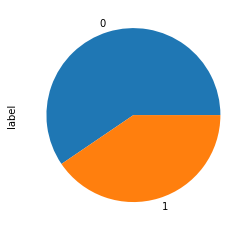

In [5]:
train['label'].value_counts().plot(kind='pie')

#### Trying to see a train pic

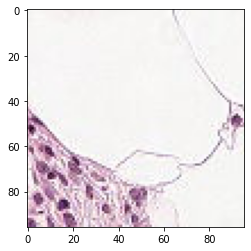

In [6]:
img = mpimg.imread('../input/histopathologic-cancer-detection/train/'+ train['id'][0] +'.tif')
imgplot = plt.imshow(img)

In [7]:
df = train.copy()
df['id'] = df['id'] + '.tif'
df['label'] = df['label'].astype(str)
train_df, test_df = train_test_split(df, test_size=0.25, 
                                      random_state=777)

In [8]:
df.head(1)

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0


In [9]:
train_df.shape

(165018, 2)

In [10]:
test_df.shape

(55007, 2)

In [11]:
train_datagen = ImageDataGenerator(rescale=1/255)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,directory="../input/histopathologic-cancer-detection/train/",
    x_col="id",
    y_col="label",
    batch_size=32,
    seed=777,
    shuffle=True, 
    class_mode="binary",
    target_size=(96,96))


Found 165018 validated image filenames belonging to 2 classes.


In [12]:

test_generator = train_datagen.flow_from_dataframe(
    dataframe=test_df,directory="../input/histopathologic-cancer-detection/train/",
    x_col="id",
    y_col="label",
    batch_size=32,
    seed=777,
    shuffle=True,
    class_mode="binary",
    target_size=(96,96))

Found 55007 validated image filenames belonging to 2 classes.


In [13]:
train_generator

## Model structure (3 set of 2 convolutional layers)

#### **Input** -> (**Conv2D** x2 -> **MaxPool2D** -> **Dropout**) x3 -> **Flatten** -> **Dense** -> **Dropout** -> **Output**





In [14]:
model = Sequential()

Activation_fun = 'relu'

## -- set1  conv2d  filters = 32 , kernel size = 3*3
model.add(Conv2D(32, (3, 3), padding='same',input_shape=(96,96,3)))
model.add(Activation(Activation_fun))
model.add(Conv2D(32, (3, 3)))
model.add(Activation(Activation_fun))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

## -- set  conv2d  filters = 64 , kernel size = 3*3
model.add(Conv2D(64, (3, 3)))
model.add(Activation(Activation_fun))
model.add(Conv2D(64, (3, 3)))
model.add(Activation(Activation_fun))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())


## -- set3  conv2d  filters = 128 , kernel size = 3*3
model.add(Conv2D(128, (3, 3)))
model.add(Activation(Activation_fun))
model.add(Conv2D(128, (3, 3)))
model.add(Activation(Activation_fun))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())


## Flatten
model.add(Flatten())
## Dense
model.add(Dense(256, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
##Dropout
model.add(Dropout(0.5))
model.add(Dense(1, activation = "sigmoid"))


2022-10-08 04:43:33.539467: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 94, 94, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 94, 94, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 47, 47, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 47, 47, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        1

In [16]:
learningrate = 0.0001
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate = learningrate), metrics=['accuracy'])

In [17]:
model.fit(x=train_generator, 
          batch_size=32, 
          epochs=10, 
          verbose=1, 
          steps_per_epoch= 2000,
          validation_freq = 1,
          validation_data=test_generator)

2022-10-08 04:43:34.236030: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
2000/2000 [==============================] - 1611s 805ms/step - loss: 0.4236 - accuracy: 0.8175 - val_loss: 0.3705 - val_accuracy: 0.8459
Epoch 2/10
2000/2000 [==============================] - 1404s 702ms/step - loss: 0.3493 - accuracy: 0.8556 - val_loss: 0.3742 - val_accuracy: 0.8493
Epoch 3/10
2000/2000 [==============================] - 1427s 713ms/step - loss: 0.3115 - accuracy: 0.8712 - val_loss: 0.3567 - val_accuracy: 0.8461
Epoch 4/10
2000/2000 [==============================] - 1422s 711ms/step - loss: 0.2797 - accuracy: 0.8865 - val_loss: 0.3723 - val_accuracy: 0.8443
Epoch 5/10
2000/2000 [==============================] - 1443s 722ms/step - loss: 0.2536 - accuracy: 0.8985 - val_loss: 0.4037 - val_accuracy: 0.8415
Epoch 6/10
2000/2000 [==============================] - 1451s 725ms/step - loss: 0.2395 - accuracy: 0.9052 - val_loss: 0.3499 - val_accuracy: 0.8461
Epoch 7/10
2000/2000 [==============================] - 1444s 722ms/step - loss: 0.2217 - accuracy: 0.9148

{'loss': [0.4235939085483551, 0.34929609298706055, 0.3114514946937561, 0.2796822786331177, 0.2536362409591675, 0.23953524231910706, 0.2217234969139099, 0.2080848217010498, 0.19231361150741577, 0.17931193113327026], 'accuracy': [0.8174999952316284, 0.8555625081062317, 0.8712031245231628, 0.8864737153053284, 0.8984687328338623, 0.9051562547683716, 0.9147576093673706, 0.919336199760437, 0.9263125061988831, 0.9318217039108276], 'val_loss': [0.3705202341079712, 0.37422630190849304, 0.3566555380821228, 0.37234145402908325, 0.403735488653183, 0.3499179184436798, 0.28759127855300903, 0.4259510040283203, 0.2491438239812851, 0.2503409683704376], 'val_accuracy': [0.8459287285804749, 0.8492737412452698, 0.8460923433303833, 0.8443288803100586, 0.8415292501449585, 0.8460741639137268, 0.8845965266227722, 0.8690711855888367, 0.9028668999671936, 0.9038667678833008]}


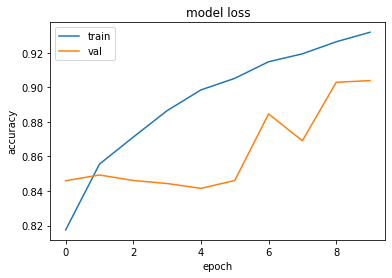

In [18]:
print(model.history.history)
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [19]:
df2 = to_pred.copy()
df2['id'] = df2['id'] + '.tif'
df2['label'] = df['label'].astype(str)


In [20]:
to_pred_gen = train_datagen.flow_from_dataframe(
    dataframe=df2,
    directory="../input/histopathologic-cancer-detection/test/",
    x_col="id",
    y_col="label",
    class_mode="binary",
    batch_size=1,
    shuffle=False,
    target_size=(96,96))

Found 57458 validated image filenames belonging to 2 classes.


In [21]:
predictions = model.predict(to_pred_gen, verbose=1)


57458/57458 [==============================] - 875s 15ms/step


In [22]:
print(predictions.shape)

(57458, 1)


In [23]:
p = predictions.copy()


In [24]:
df3 = to_pred.copy()
df3.drop('label',axis = 1)
df3['label'] = p

In [25]:
df3.to_csv("submission.csv", index = False, header = True)